# flower classifier with PyTorch

for every project we should follow *three* steps:
#### 1. preparing the data
#### 2. create a model
#### 3. evaluate the model

## 1. Preparing the data

for this project we have a flower dataset which contains 17 types of flower that exist in *17_flowers* directory.
the dataset contains *train* and *test* data.

for reading data and prepare those, there are different ways, for example: using glob, using os, using pytorch, ...
here we use pythorch for reading and preparing the data.

In [1]:
import torch

# set device for modeling
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 1.1_ using torchvision.transforms to build train and test transforms

In [8]:
from torchvision import transforms

train_dir = '17_flowers/train'
test_dir = '17_flowers/test'

In [9]:
train_transform = transforms.Compose([transforms.Resize(size=(64, 64)), 
                                     transforms.RandomHorizontalFlip(0.5), 
                                     transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(64, 64)), 
                                    transforms.ToTensor()])

### 1.2_ using torchvision.datasets.ImageFolder() to create torch dataset from our data and then split them to batches with torch.utils.data.DataLoader().

In [19]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def create_dataset(train_dir, test_dir, train_transform, test_transform, batch_size, shuffle):
    train_data = ImageFolder(root=train_dir, transform=train_transform)
    test_data = ImageFolder(root=test_dir, transform=test_transform)
    
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
    
    
    return train_loader, test_loader, train_data.classes

In [20]:
BATCH_SIZE = 64

train_loader, test_loader, classes = create_dataset(train_dir=train_dir, 
                                                   test_dir=test_dir, 
                                                   train_transform=train_transform, 
                                                   test_transform=test_transform, 
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True)
classes

['bluebell',
 'buttercup',
 'colts_foot',
 'cowslip',
 'crocus',
 'daffodil',
 'daisy',
 'dandelion',
 'fritillary',
 'iris',
 'lily_valley',
 'pansy',
 'snowdrop',
 'sunflower',
 'tigerlily',
 'tulip',
 'windflower']

In [38]:
# see an image in dataloader
img = next(iter(train_loader))[0][0]

img, img.shape

(tensor([[[0.6549, 0.6431, 0.5725,  ..., 0.4745, 0.4824, 0.5451],
          [0.6275, 0.6039, 0.6039,  ..., 0.4431, 0.5020, 0.5451],
          [0.5255, 0.5490, 0.5882,  ..., 0.4196, 0.4941, 0.4941],
          ...,
          [0.4392, 0.4510, 0.4784,  ..., 0.5137, 0.5098, 0.6275],
          [0.4510, 0.4667, 0.4824,  ..., 0.4824, 0.5137, 0.5725],
          [0.5686, 0.5294, 0.4549,  ..., 0.5843, 0.6549, 0.6314]],
 
         [[0.7529, 0.7686, 0.7333,  ..., 0.6471, 0.6627, 0.7255],
          [0.7490, 0.7451, 0.7686,  ..., 0.6314, 0.6784, 0.7255],
          [0.6745, 0.7137, 0.7765,  ..., 0.6039, 0.6745, 0.6902],
          ...,
          [0.6588, 0.6745, 0.6863,  ..., 0.6471, 0.6392, 0.7059],
          [0.6039, 0.6510, 0.7020,  ..., 0.5804, 0.6118, 0.6471],
          [0.7451, 0.7176, 0.6510,  ..., 0.6784, 0.7098, 0.6784]],
 
         [[0.4588, 0.5059, 0.5020,  ..., 0.3608, 0.3765, 0.5373],
          [0.4745, 0.4706, 0.4941,  ..., 0.3098, 0.4431, 0.5373],
          [0.3922, 0.4000, 0.4353,  ...,

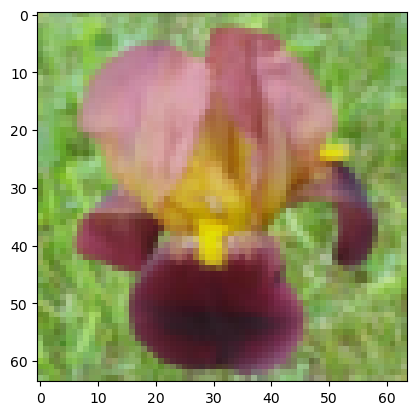

In [41]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))